<a id = "1"></a><br>
# Load Python Pakages


In [2]:
%pip install xgboost

  Using cached xgboost-2.1.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.0-py3-none-win_amd64.whl (124.9 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

#preprocessing

#feature engineering
from sklearn.feature_selection import mutual_info_classif


#algorithms
from xgboost import XGBClassifier
import xgboost as xgb


#model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay



random_state = 42


<a id = "2"></a><br>
#  First look to data

In [4]:
# Read the data
train_df = pd.read_csv('C:\\kaggle\\Binary_Classification_of_Insurance_Cross_Selling\\data\\train.csv', index_col=[0])
test_df = pd.read_csv('C:\\kaggle\\Binary_Classification_of_Insurance_Cross_Selling\\data\\test.csv', index_col=[0])
original_df = pd.read_csv('C:\\kaggle\Binary_Classification_of_Insurance_Cross_Selling\\data\\health-insuran-cross-sell-prediction_train.csv', index_col=[0])

train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [8]:
print(train_df.shape)
print(test_df.shape)
print(original_df.shape)

(11504798, 11)
(7669866, 10)
(381109, 11)


<a id = "3"></a><br>
## Descpriptive statistics

In [3]:
#numerical feature descriptive statistics

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Region_Code,11504798.0,26.418690,12.991590,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0
Response,11504798.0,0.122997,0.328434,0.0,0.0,0.0,0.0,1.0


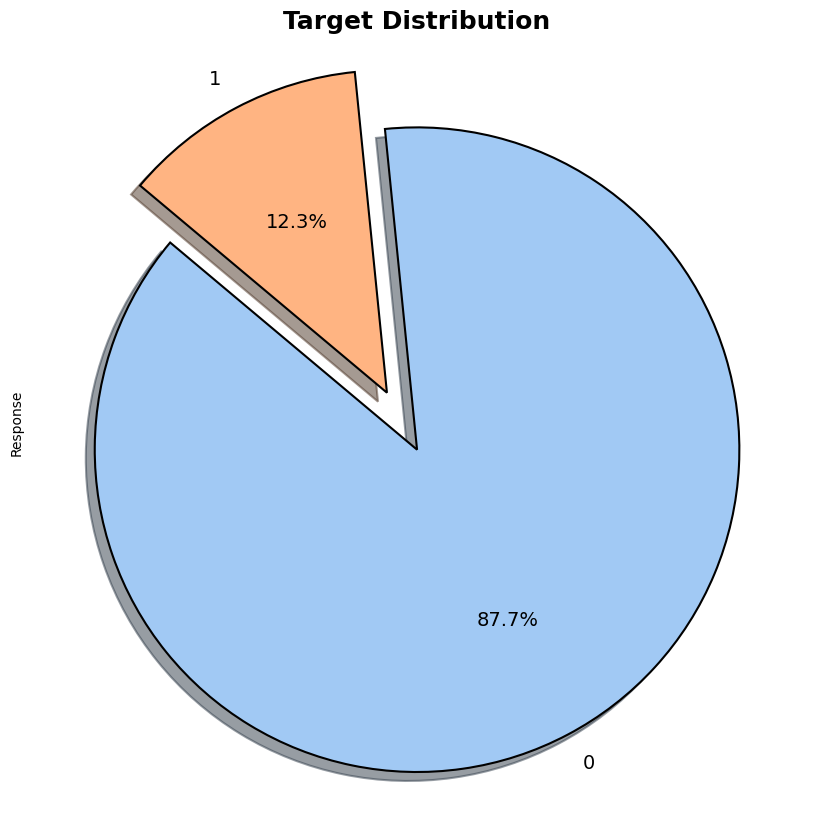

In [4]:
#Target frequency

plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.1 for _ in range(train_df['Response'].nunique())]

# Plotting
train_df.groupby('Response')['Response'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

## Grouping features for preprocessing purposes

In [11]:
train_df.nunique().sort_values()

Gender                      2
Driving_License             2
Previously_Insured          2
Vehicle_Damage              2
Response                    2
Vehicle_Age                 3
Region_Code                54
Age                        66
Policy_Sales_Channel      152
Vintage                   290
Annual_Premium          51728
dtype: int64

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [5]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Response"]

target = "Response"

binary_features = ['Previously_Insured','Driving_License']

categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']


train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')
original_df[categorical_features] = original_df[categorical_features].astype('category')


continuous_features = list(set(feature_list) - set(binary_features)- set(categorical_features))

assert feature_list.sort() == (continuous_features + binary_features + categorical_features).sort()

<a id = "4"></a><br>
# Exploratory Data Analysis

In [6]:
#Data is huge just take some sample for eda
eda_df = train_df.sample(frac= 0.01)

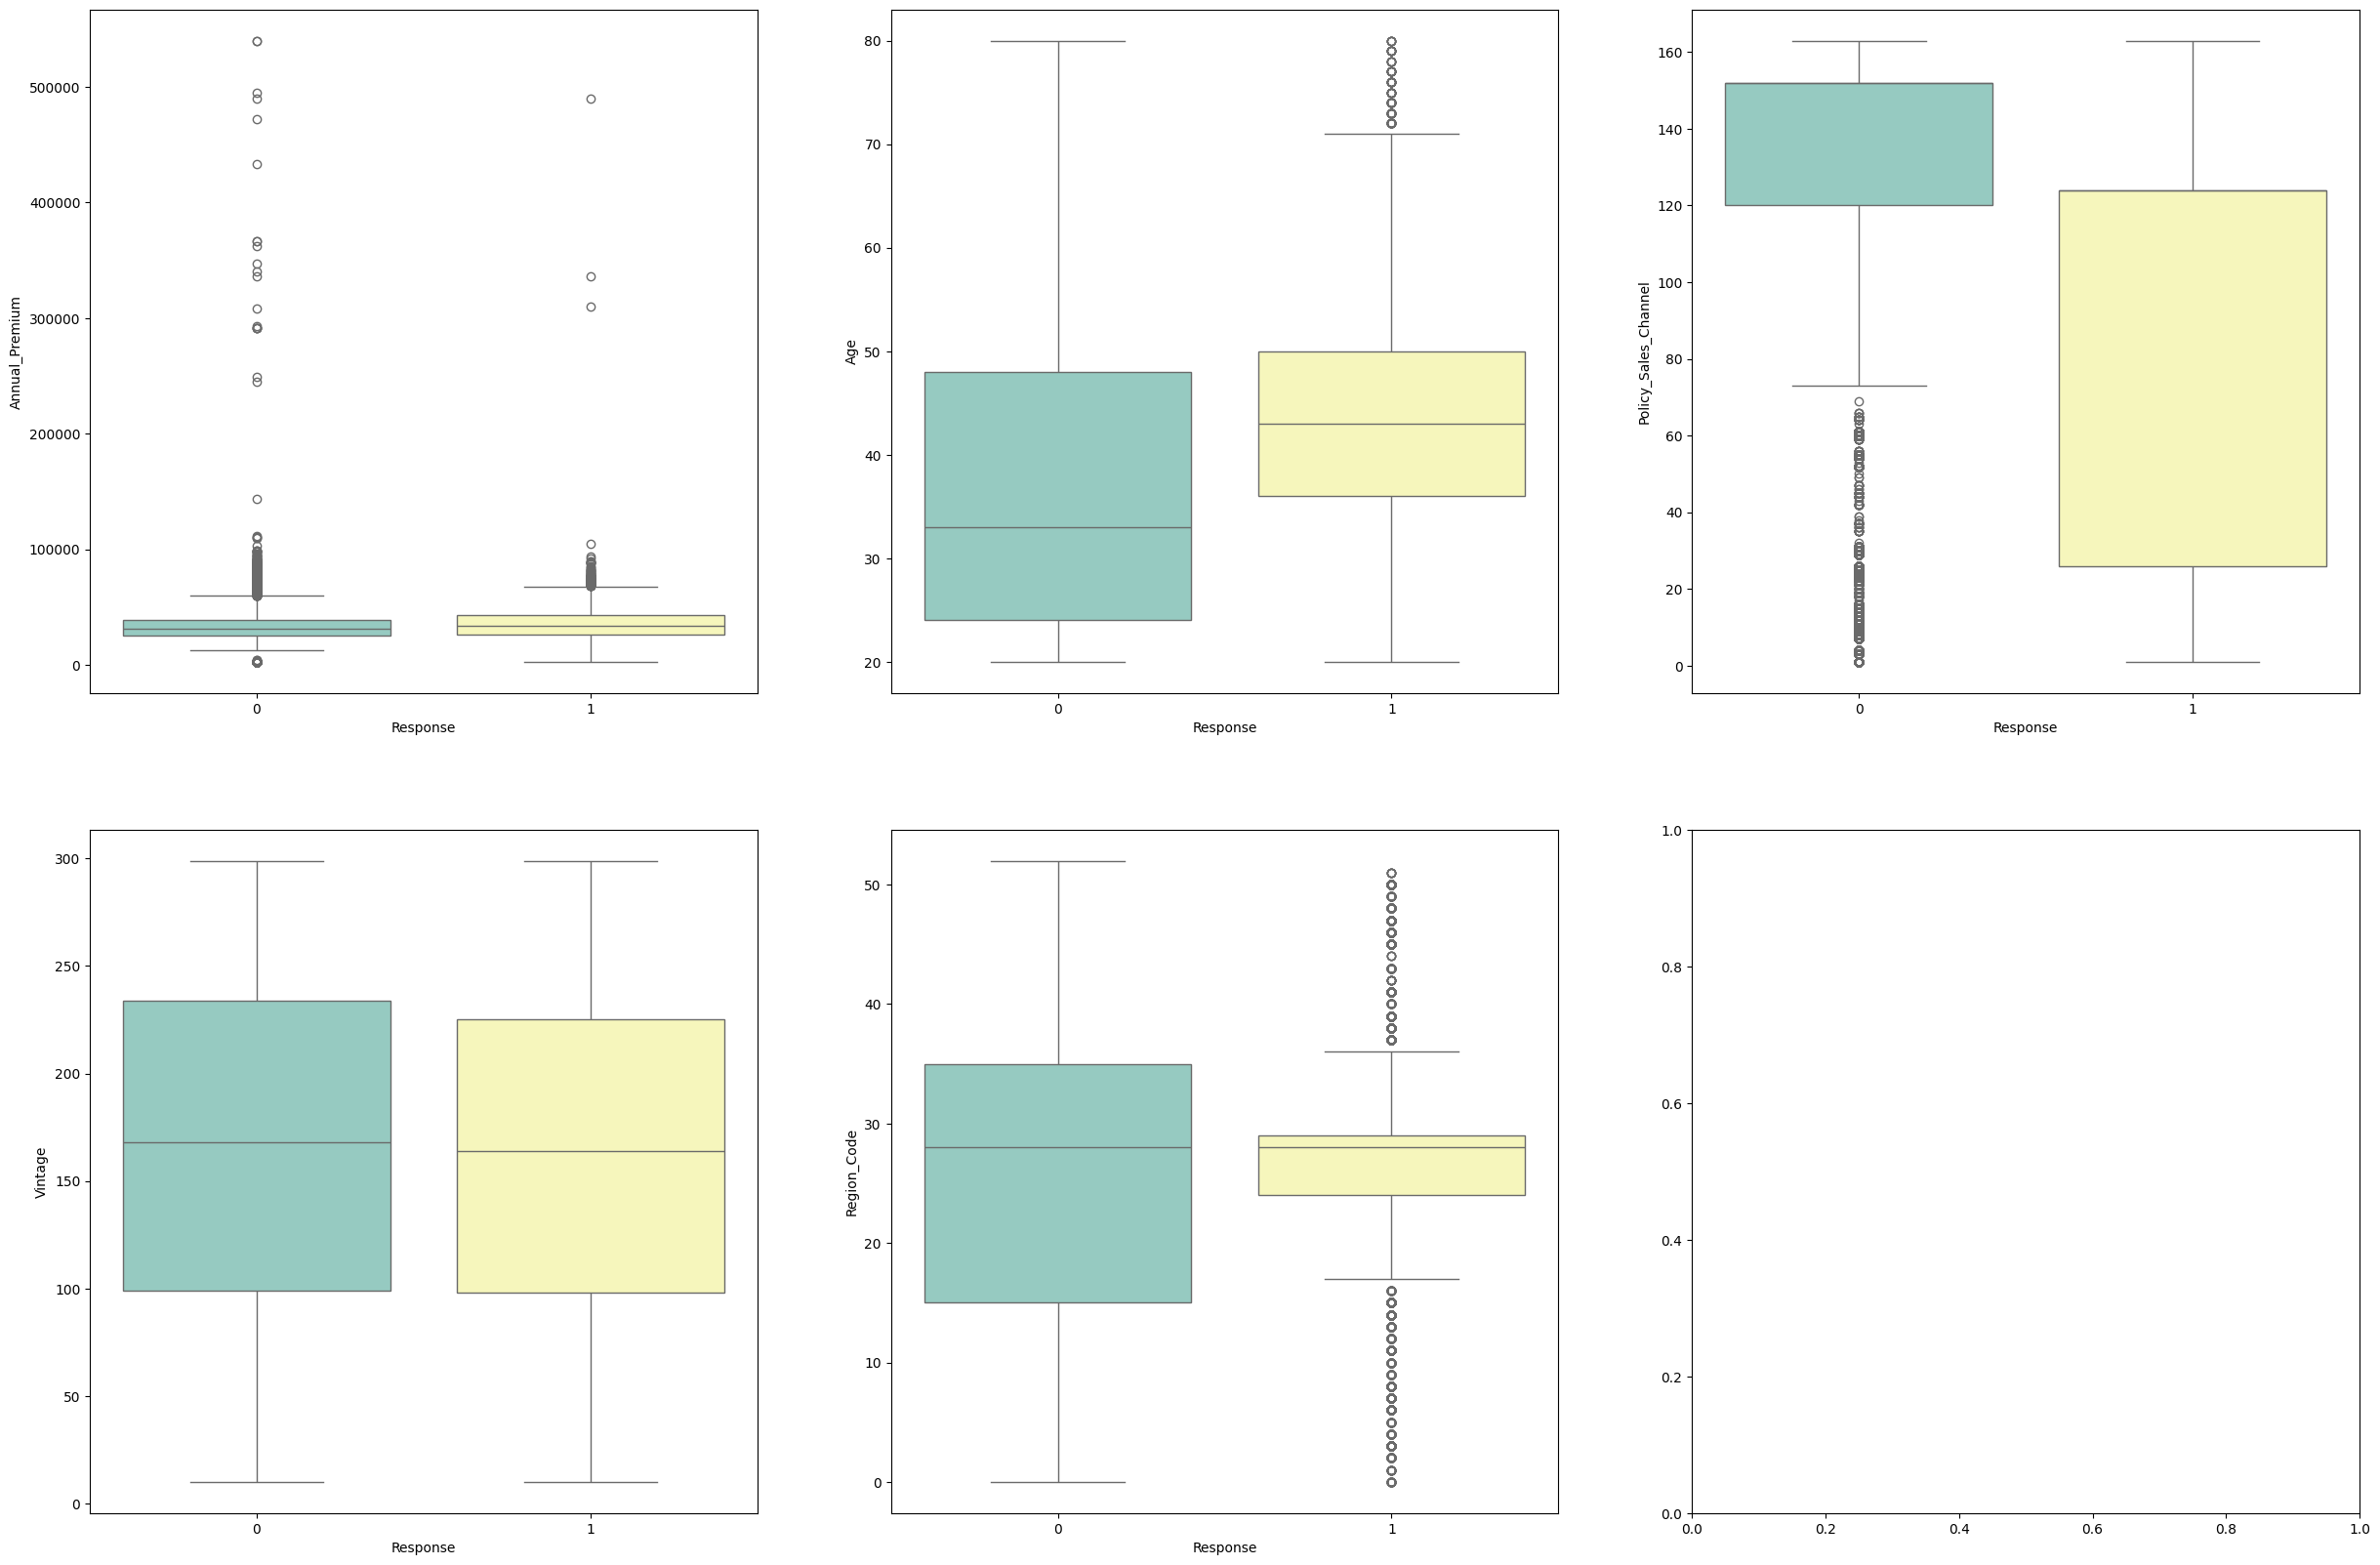

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Response', y=var, data=eda_df, ax=subplot, palette='Set3')

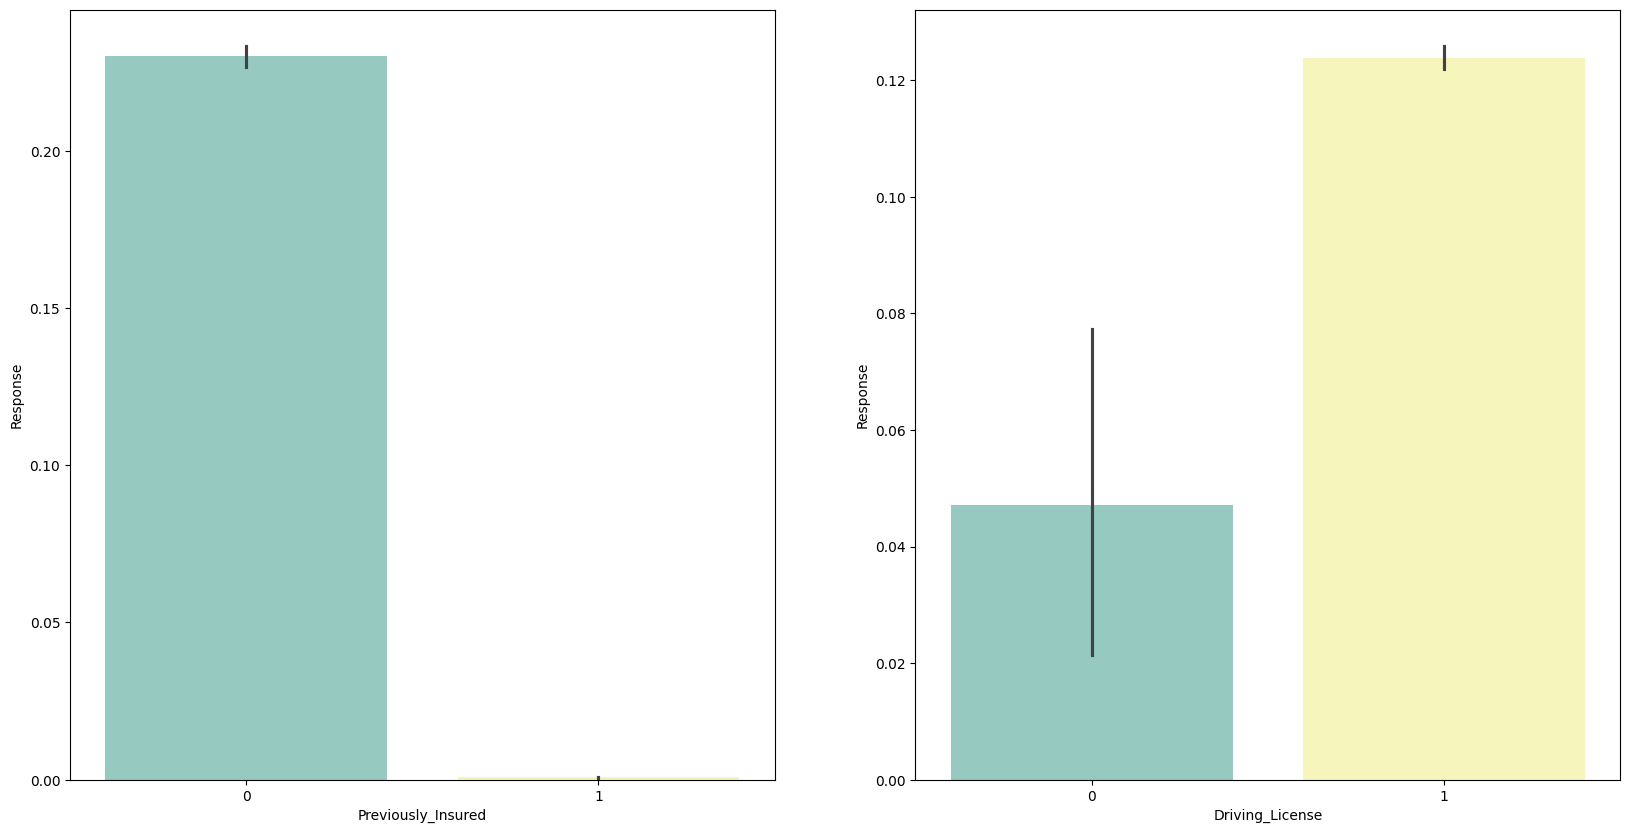

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for var, subplot in zip(binary_features, ax.flatten()):
    sns.barplot(x=var, y= 'Response', data=eda_df, ax=subplot, palette='Set3')

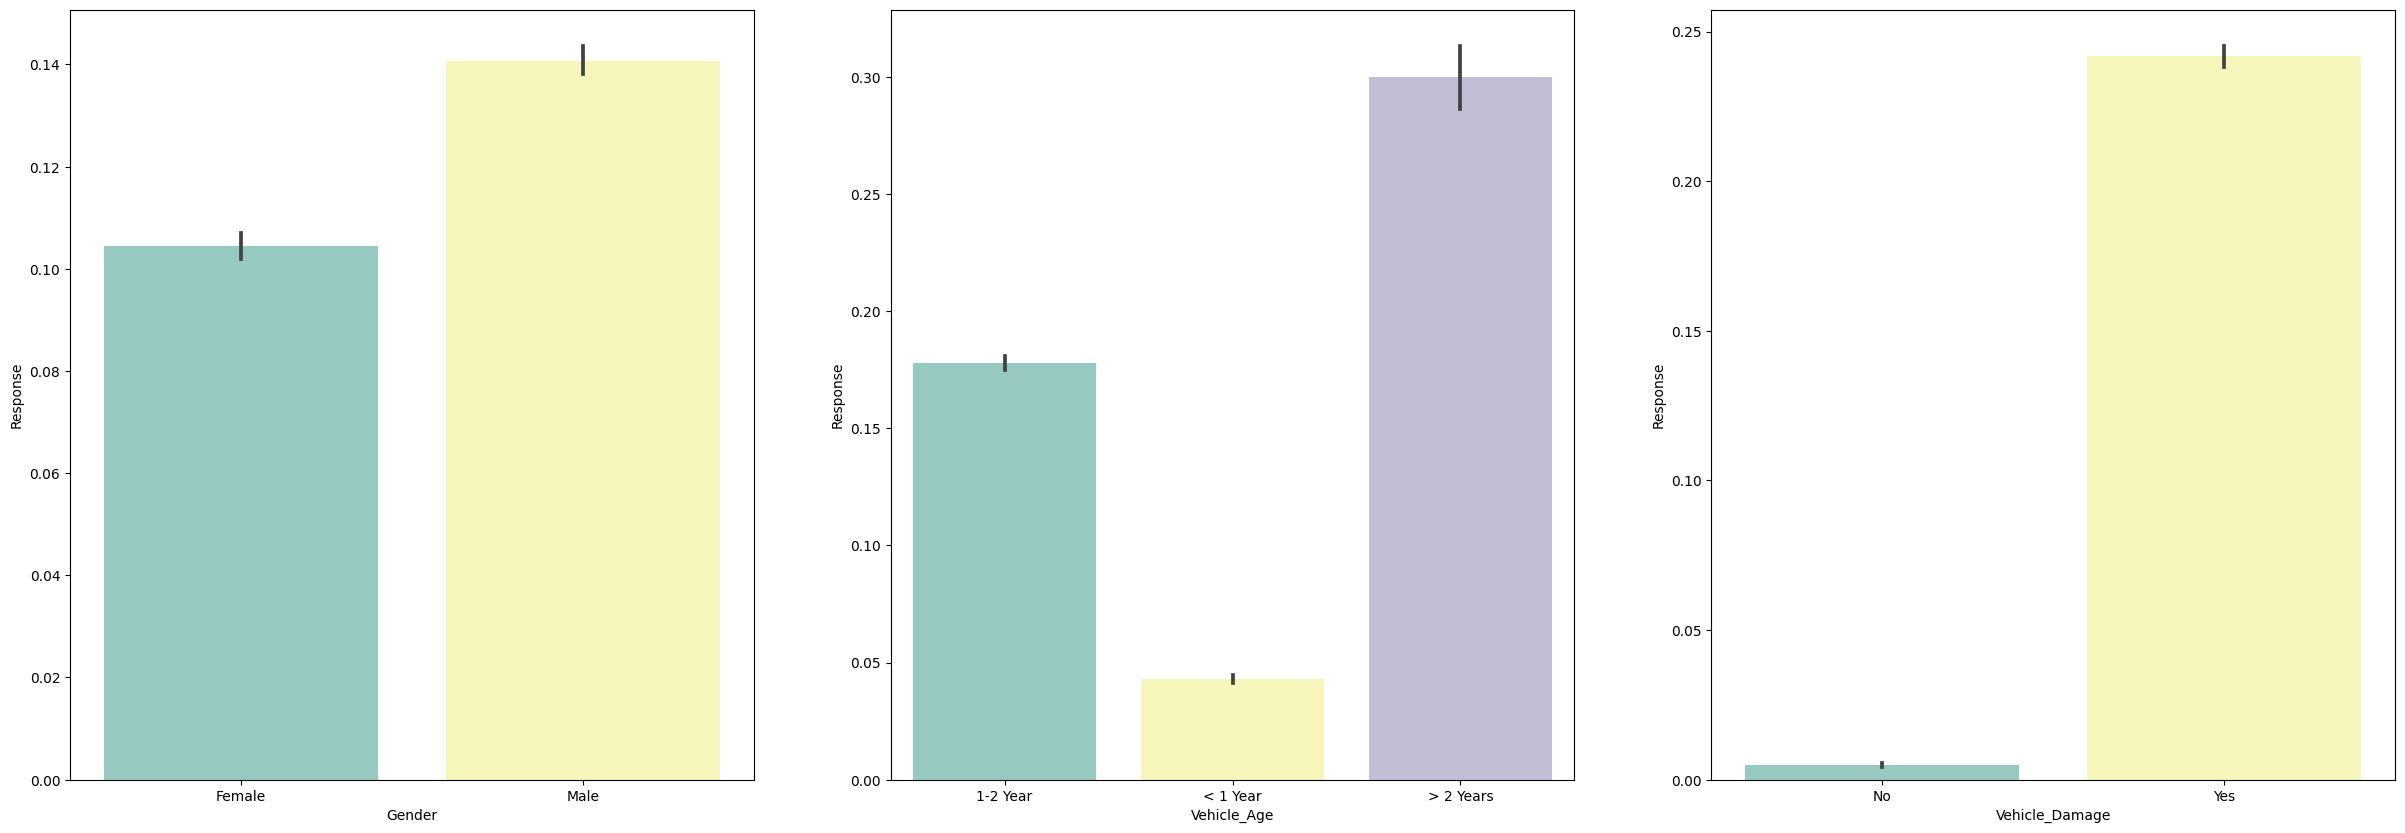

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for var, subplot in zip(categorical_features, ax.flatten()):
    sns.barplot(x=var, y= 'Response', data=eda_df, ax=subplot, palette='Set3')

<a id = "5"></a><br>
# Feature Engineering

In [17]:
# determine the mutual information for numerical features

mutual_df = eda_df[continuous_features+binary_features ]
y_sampled = eda_df.Response
mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")


,Numerical_Feature_MI
Previously_Insured,0.098047
Policy_Sales_Channel,0.049099
Age,0.035037
Annual_Premium,0.022286
Driving_License,0.019498
Vintage,0.015081
Region_Code,0.014682


In [18]:
mutual_df_categorical = eda_df[categorical_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_categorical, y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

,Categorical_Feature_MI
Vehicle_Damage,0.091936
Vehicle_Age,0.043206
Gender,0.014710


<a id = "7"></a><br>
# Modeling and hyperparameter tuning

In [7]:
y = train_df.Response
train_df = train_df.drop("Response", axis=1)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
#Use original data, but only in train samples don't leak to test set
X_train = pd.concat([original_df.drop('Response', axis=1), X_train]).reset_index(drop=True)
y_train = pd.concat([original_df['Response'], y_train]).reset_index(drop=True)

In [16]:
%%time

#Parameters are comming from OPTUNA, but I tunned them with %1 percent of the data.

model = XGBClassifier(
    n_estimators=10000,
    eta=0.05,
    alpha = 0.2545607592482198,
    subsample = 0.8388163485383147, 
    colsample_bytree = 0.2732499701466825, 
    max_depth = 16,
    min_child_weight = 5,
    gamma = 0.0017688666476104672,
    early_stopping_rounds=50,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    eval_metric='auc',
    random_state=random_state,
    max_bin=262143, #a weird max_bin, for reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516265
    enable_categorical=True
)


# Train the model with early stopping
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=500
)

# Print the best iteration
print("Best iteration:", model.best_iteration)

# Use the underlying booster to predict on validation set using the best iteration
booster = model.get_booster()
y_pred_prob = booster.predict(xgb.DMatrix(X_val, enable_categorical=True), iteration_range=(0, model.best_iteration + 1))
auc = roc_auc_score(y_val, y_pred_prob)
print(f"Validation AUC: {auc:.5f}")

[0]	validation_0-auc:0.67197
[500]	validation_0-auc:0.88863
[1000]	validation_0-auc:0.89014
[1500]	validation_0-auc:0.89090
[2000]	validation_0-auc:0.89135
[2265]	validation_0-auc:0.89153
Best iteration: 2216
Validation AUC: 0.89154
CPU times: total: 11min 28s
Wall time: 11min 10s


<a id = "8"></a><br>
# Explainable ML & Feature importances

In [18]:
%pip install yellowbrick

   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/282.6 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/282.6 kB 435.7 kB/s eta 0:00:01
   ------------------------------- -------- 225.3/282.6 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 282.6/282.6 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


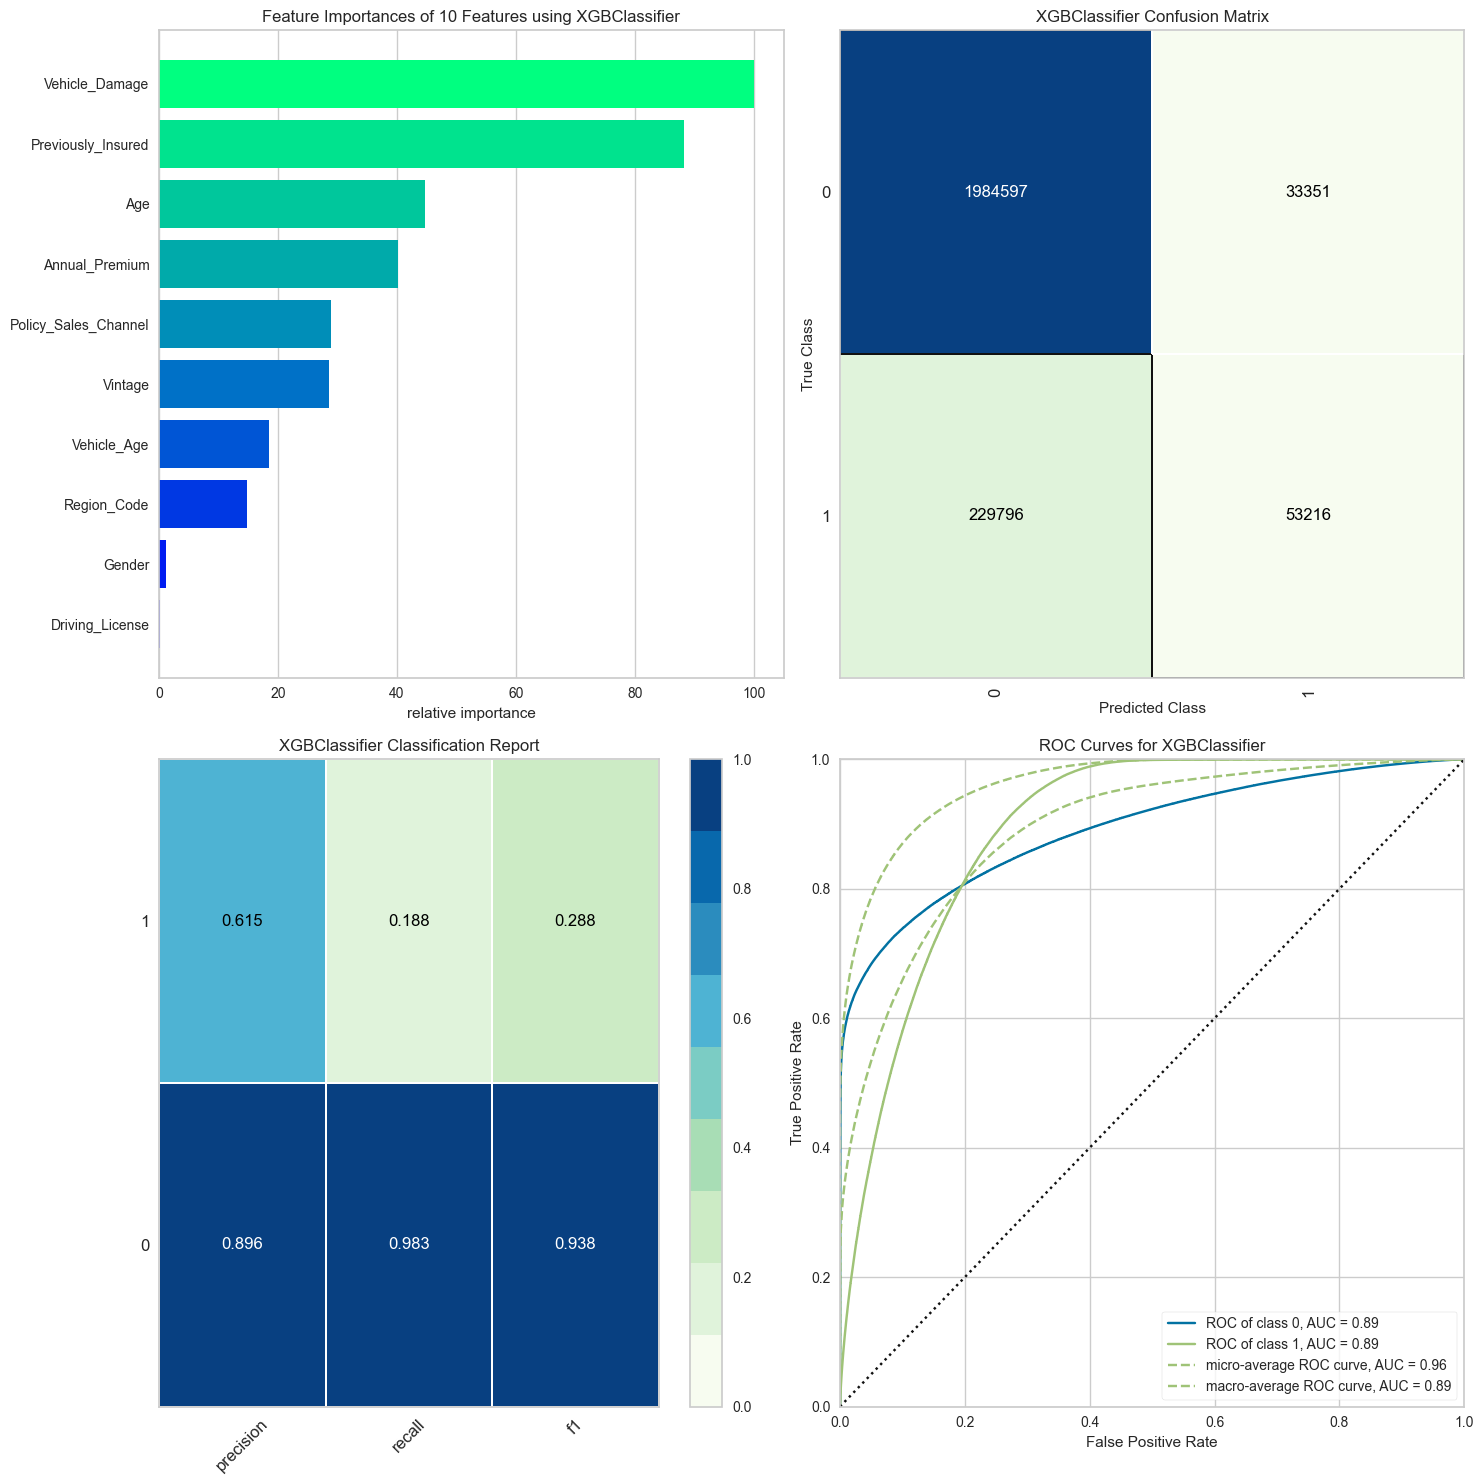

In [19]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, DiscriminationThreshold

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

model = model
model.importance_type = 'total_gain'

visualgrid = [
    FeatureImportances(model,  ax=axes[0][0], colormap= 'winter'),
    ConfusionMatrix(model, ax=axes[0][1], cmap= 'GnBu'),
    ClassificationReport(model, ax=axes[1][0], cmap= 'GnBu'),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_val, y_val)
    viz.finalize()

plt.show()

Shap is another tool for explainability. 

In [23]:
%pip install shap

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   ---------------------------- ---------- 327.7/456.1 kB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 9.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 4.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------ --------------------------------- 0.4/2.7 MB 13.9 MB/s eta 0:00:01
   ------------ --------------------------- 0.8/2.7 MB 10.8 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.7 MB 10.6 MB/s eta 0:00:01
   ------------------------- -------------- 1.7/2.7 MB 9.9 MB/s eta 0:00:01
   -----------------


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


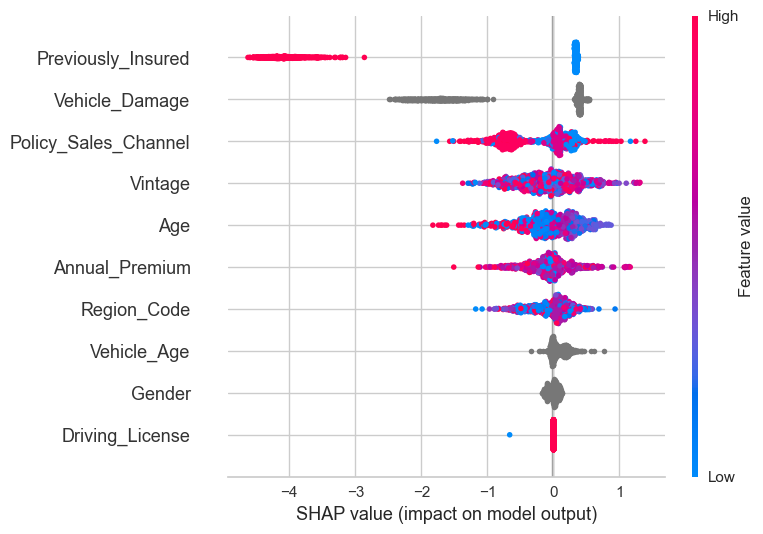

In [24]:
import shap

model = model

explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
#interventional argument breaks feature dependencies and provides better estimate

#It takes time just take some sample
test_explain = X_val.sample(n=1000, random_state=random_state)

shap_values = explainer.shap_values(test_explain, check_additivity=False )

# Summary plot of feature importance
shap.summary_plot(shap_values, test_explain, max_display = len(X_val) )

Model importance score and SHAP agree on the most and least important features.

<a id = "14"></a><br>
# Submission

In [25]:
test_df_d = xgb.DMatrix(test_df, enable_categorical=True)

In [26]:
sub_preds = booster.predict(test_df_d,iteration_range=(0, model.best_iteration + 1))

In [30]:
output = pd.DataFrame({'id': test_df.index,
                       'Response': sub_preds})

output.info


<bound method DataFrame.info of                id  Response
0        11504798  0.004102
1        11504799  0.561159
2        11504800  0.234168
3        11504801  0.000140
4        11504802  0.071644
...           ...       ...
7669861  19174659  0.200482
7669862  19174660  0.000150
7669863  19174661  0.000250
7669864  19174662  0.575829
7669865  19174663  0.000112

[7669866 rows x 2 columns]>

In [29]:
output.to_csv("C:\kaggle\Binary_Classification_of_Insurance_Cross_Selling\data\submission.csv", index=False)


<a id = "15"></a><br>
# Just For Fun: Playing with probability threshold

In [ ]:
from ipywidgets import interact, FloatSlider


fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Calculate the Youden Index for each threshold
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
max_youden_index = np.max(youden_index)

print(f"Optimal threshold: {optimal_threshold}")
print(f"Maximum Youden Index: {max_youden_index}")

# Function to update the confusion matrix based on the selected threshold
def update_confusion_matrix(threshold):
    # Apply the threshold to get binary predictions
    final_preds = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_val, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix at threshold = {threshold:.2f}')
    plt.show()

# Plot ROC curve and Youden Index
plt.figure(figsize=(10, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Subplot 2: Youden Index
plt.subplot(1, 2, 2)
plt.plot(thresholds, youden_index, label='Youden Index')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Youden Index')
plt.title('Youden Index vs Threshold')
plt.legend()

plt.tight_layout()
plt.show()

#Playing with slider bar 
interact(update_confusion_matrix, threshold=FloatSlider(value=optimal_threshold, min=0.0, max=1.0, step=0.01))
